In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips, \
                            load_sim_dir

In [9]:
dirs_ls_output = """asymptomatic_p_june_realistic.1590695831.573555
drwxrwxr-x  15 jmc678 pug-jmc678  4096 May 28 15:57 asymptomatic_p_fall_realistic.1590695831.5708697
drwxrwxr-x  15 jmc678 pug-jmc678  4096 May 28 15:57 asymptomatic_p_fall_realistic_testing.1590695831.5708034""".split('\n')
sim_dirs = [ls_output.split(' ')[-1] for ls_output in dirs_ls_output]
for d in sim_dirs:
    print(d)

asymptomatic_p_june_realistic.1590695831.573555
asymptomatic_p_fall_realistic.1590695831.5708697
asymptomatic_p_fall_realistic_testing.1590695831.5708034


In [10]:
sim_results = {}
for d in sim_dirs:
    if 'june_slightly_pessimistic_testing' in d:
        label = 'june_slightly_pessimistic_testing'
    elif 'june_slightly_optimistic_testing' in d:
        label = 'june_slightly_optimistic_testing'
    elif 'june_realistic_testing' in d:
        label = 'june_realistic_testing'
    elif 'june_slightly_pessimistic' in d:
        label = 'june_slightly_pessimistic'
    elif 'june_slightly_optimistic' in d:
        label = 'june_slightly_optimistic'
    elif 'june_realistic' in d:
        label = 'june_realistic'
    elif 'fall_slightly_pessimistic_testing' in d:
        label = 'fall_slightly_pessimistic_testing'
    elif 'fall_slightly_optimistic_testing' in d:
        label = 'fall_slightly_optimistic_testing'
    elif 'fall_realistic_testing' in d:
        label = 'fall_realistic_testing'
    elif 'fall_slightly_pessimistic' in d:
        label = 'fall_slightly_pessimistic'
    elif 'fall_slightly_optimistic' in d:
        label = 'fall_slightly_optimistic'
    elif 'fall_realistic' in d:
        label = 'fall_realistic'
    else:
        print("could not find label for {}".format(d))
        label = 'unlabeled'
    
    if 'realistic' not in d:
        print("only loading realistic sims for now; skipping {}".format(d))
        continue
    
    sublabel = d.split('_' + label)[0]
    
    if label not in sim_results:
        sim_results[label] = {}
    
    sim_results[label][sublabel] = load_sim_dir("/nfs01/covid_sims/" + d, verbose=False)
    print("done loading {}".format(d))

done loading asymptomatic_p_june_realistic.1590695831.573555
done loading asymptomatic_p_fall_realistic.1590695831.5708697
done loading asymptomatic_p_fall_realistic_testing.1590695831.5708034


In [11]:
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

def modify_tick_labels(labels, axis, use_int_labels):
    assert(axis in ['x', 'y'])
    new_labels = []
    for label in labels:
        txt = label.get_text()
        if txt == '':
            new_labels.append('')
        else: 
            if axis == 'x':
                val = label._x
            else:
                val = label._y
            
            if use_int_labels:
                newtxt = str(int(val))
            else:
                newtxt = str(float(val))
            
            new_labels.append(newtxt)
    return new_labels
            

def extract_severities(dfs, hospitalizations_only=True):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        if hospitalizations_only:
            subdf = df[['severity_2', 'severity_3']]
        else:
            subdf = df[['severity_0', 'severity_1', 'severity_2', 'severity_3']]

        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return severities
def average_cumulative_severe(dfs):
    severities = []
    for df in dfs:
        all_cols = set(df.columns)
        new_cols = set(['cumulative_mild', 
                        'cumulative_severe', 
                        'severity_0', 
                        'severity_1', 
                        'severity_2', 
                        'severity_3'])
        main_cols = all_cols - new_cols
        subdf = df[list(main_cols)]
        popsize = sum(subdf.iloc[0])
        
        subdf = df[['severity_2', 'severity_3']]
        severe = sum(subdf.iloc[subdf.shape[0]-1])
        
        severities.append(100 * severe / popsize)
    return np.mean(severities)

def avg_cum_severe_quantile(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.mean(severities), np.quantile(severities, q_high)

def cum_severe_quantiles(dfs, q_low, q_high):
    severities = extract_severities(dfs)
    return np.quantile(severities, q_low), np.quantile(severities, 0.5), np.quantile(severities, q_high)

def cum_infection_quantiles(dfs, q_low, q_high):
    severities = extract_severities(dfs, hospitalizations_only=False)
    return np.quantile(severities, q_low), np.quantile(severities, 0.5), np.quantile(severities, q_high)

def plot_many_dfs(sim_output_dict, yaxisfn, ylabel="", xlabel="", title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            ys.append(yaxisfn(dfs))
        plt.plot(xs, ys, marker='o', label=sim_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


def truncate(val, y_min, y_max):
    return max(min(val, y_max), y_min)
    
def plot_many_dfs_quantiles(sim_output_dict, yaxisfn, normalize_x_axis, x_log_scale=False, 
                            y_log_scale=False,
                            q_low=0.05, q_high=0.95, 
                            y_min = 0, y_max = 5,
                            ylabel="", xlabel="", title="", 
                            figsize=(10,6), alpha=0.1, color=None, savefig_name = None,
                            use_x_int_labels=False, use_y_int_labels=False):
    # assn: yaxisfn(dfs) returns a tuple (q_low_val, avg, q_high_val)
    epsilon=1e-6
    plt.figure(figsize=figsize)
    if x_log_scale:
        plt.xscale("log")
    if y_log_scale:
        plt.yscale("log")
        #_, _, ymin, _ = plt.axis()
        #plt.ylim(bottom=max(1e-2, ymin))
    else:
        plt.ylim(y_min, y_max)
    
    for sim_label, sim_output in sim_output_dict.items():
        xs = []
        ys = []
        q_low_vals = []
        q_high_vals = []
        for sim_parameter_name, dfs in sim_output.items():
            # compute x-value assuming that sim_param_name is of form 'varied_param_name.value'
            param_val = float('.'.join(sim_parameter_name.split('.')[1:]))
            if normalize_x_axis:
                xs.append(param_val * 100)
            else:
                xs.append(param_val)
            # yaxisfn is a function that takes in a list of trajectory dataframes and
            # produces an output metric
            q_low_val, avg, q_high_val = yaxisfn(dfs, q_low, q_high)
            if not y_log_scale:
                ys.append(truncate(avg, y_min, y_max))
                q_low_vals.append(truncate(q_low_val, y_min, y_max))
                q_high_vals.append(truncate(q_high_val, y_min, y_max))
            else:
                ys.append(avg + epsilon)
                q_low_vals.append(q_low_val + epsilon)
                q_high_vals.append(q_high_val + epsilon)
        
        sorted_points = sorted(zip(xs, ys, q_low_vals, q_high_vals), key=lambda x: x[0])
        xs = [p[0] for p in sorted_points]
        ys = [p[1] for p in sorted_points]
        q_low_vals = [p[2] for p in sorted_points]
        q_high_vals = [p[3] for p in sorted_points]
        
        if color == None:
            plt.plot(xs, ys, marker='o', label=sim_label)
            plt.fill_between(xs, q_low_vals, q_high_vals, alpha=alpha)
        else:
            plt.plot(xs, ys, marker='o', label=sim_label, color=color)
            plt.fill_between(xs, q_low_vals, q_high_vals, alpha=alpha, color=color)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    
    
    
    plt.draw()
    
    ax = plt.gca()
    
    
    labels = ax.get_xmajorticklabels()
    new_labels = modify_tick_labels(labels, "x", use_x_int_labels)
    ax.set_xticklabels(new_labels)
    
    labels = ax.get_xminorticklabels()
    new_labels = modify_tick_labels(labels, "x", use_x_int_labels)
    ax.set_xticklabels(new_labels, minor=True)
    
    labels = ax.get_ymajorticklabels()
    new_labels = modify_tick_labels(labels, "y", use_y_int_labels)
    ax.set_yticklabels(new_labels)
    
    labels = ax.get_yminorticklabels()
    new_labels = modify_tick_labels(labels, "y", use_y_int_labels)
    ax.set_yticklabels(new_labels, minor=True)
    
    
    if savefig_name:
        plt.savefig("/nfs01/covid_figs/" + savefig_name + ".pdf")
    plt.show()

In [12]:

plot_labels = {
    'daily_contacts': 'Average Contacts per Person per Day',
    'severe_self_reporting': 'Daily Symptomatic Self-Reporting Likelihood(%)',
    'prevalence': 'Initial Prevalence (% of Total Population)',
    'mild_self_reporting': 'Daily Asymptomatic Self-Reporting Likelihood(%)',
    'exposed_infection_p': 'Transmission Likelihood per Contact (%)',
    'contact_isolations': 'Isolations per Contact Trace',
    'contact_delay': 'Contact Trace Delay (Days)',
    'asymptomatic_p': 'Percentage of Cases Asymptomatic (%)'
}

normalize_params = {
    'daily_contacts': False,
    'severe_self_reporting': True,
    'prevalence': True,
    'mild_self_reporting': True,
    'exposed_infection_p': True,
    'contact_isolations': False,
    'contact_delay': False,
    'asymptomatic_p': True,
}

plot_log_scale = {
    'daily_contacts': True,
    'severe_self_reporting': False,
    'prevalence': True,
    'mild_self_reporting': False,
    'exposed_infection_p': True,
    'contact_isolations': False,
    'contact_delay': False,
    'asymptomatic_p': True
}

use_x_int_labels = {
    'daily_contacts': True,
    'severe_self_reporting': True,
    'prevalence': False,
    'mild_self_reporting': True,
    'exposed_infection_p': False,
    'contact_isolations': False,
    'contact_delay': True,
    'asymptomatic_p': False
}

# Old Age-Severity Distribution: Asymptomatic % Severity

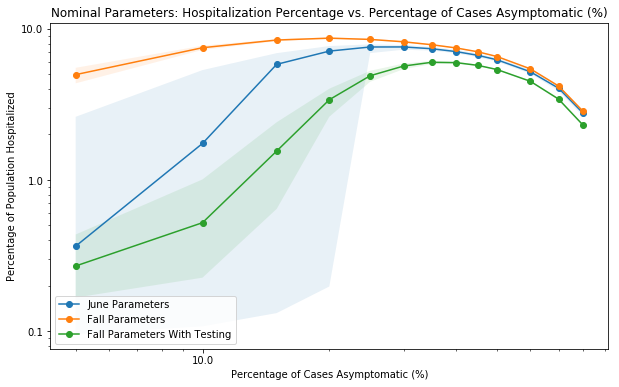

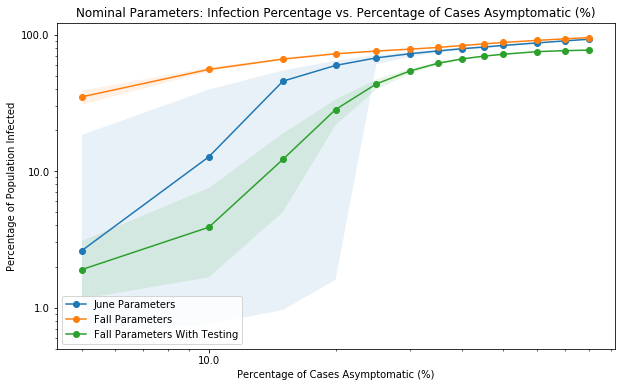

In [13]:
june = sim_results['june_realistic']
fall = sim_results['fall_realistic']
fall_testing = sim_results['fall_realistic_testing']

for sublabel in ['asymptomatic_p']:
    
    plot_many_dfs_quantiles({'June Parameters': june[sublabel], 
                             'Fall Parameters': fall[sublabel],
                             'Fall Parameters With Testing': fall_testing[sublabel]}, 
                            cum_severe_quantiles,
                            normalize_params[sublabel], x_log_scale=plot_log_scale[sublabel],
                     xlabel=plot_labels[sublabel], ylabel="Percentage of Population Hospitalized",
                     title="Nominal Parameters: Hospitalization Percentage vs. {}".format(plot_labels[sublabel]), 
                               q_low=0.1, q_high=0.9, alpha=0.1, y_min = 0, y_max=5, y_log_scale=True,
                             use_x_int_labels=False)
    
    plot_many_dfs_quantiles({'June Parameters': june[sublabel], 
                             'Fall Parameters': fall[sublabel],
                             'Fall Parameters With Testing': fall_testing[sublabel]}, 
                            cum_infection_quantiles,
                            normalize_params[sublabel], x_log_scale=plot_log_scale[sublabel],
                     xlabel=plot_labels[sublabel], ylabel="Percentage of Population Infected",
                     title="Nominal Parameters: Infection Percentage vs. {}".format(plot_labels[sublabel]), 
                               q_low=0.1, q_high=0.9, alpha=0.1, y_min = 0, y_max=5, y_log_scale=True,
                             use_x_int_labels=False)

# New Age-Severity Distribution: Asymptotic % Sensitivity Analysis

In [14]:
updated_sim_dirs_ls_output = """asymptomatic_p_fall_realistic_updated_age_severity.1590698335.5952137
drwxrwxr-x  15 jmc678 pug-jmc678  4096 May 28 16:38 asymptomatic_p_fall_realistic_updated_age_severity_testing.1590698335.5951662""".split('\n')
updated_sim_dirs = [ls_output.split(' ')[-1] for ls_output in updated_sim_dirs_ls_output]
for d in updated_sim_dirs:
    print(d)

asymptomatic_p_fall_realistic_updated_age_severity.1590698335.5952137
asymptomatic_p_fall_realistic_updated_age_severity_testing.1590698335.5951662


In [15]:
updated_sim_results = {}
for d in updated_sim_dirs:
    if 'fall_realistic_updated_age_severity_testing' in d:
        label = 'fall_realistic_updated_age_severity_testing'
    elif 'fall_realistic_updated_age_severity' in d:
        label = 'fall_realistic_updated_age_severity'
    else:
        print("could not find label for {}".format(d))
        label = 'unlabeled'
    
    if 'realistic' not in d:
        print("only loading realistic sims for now; skipping {}".format(d))
        continue
    
    sublabel = d.split('_' + label)[0]
    
    if label not in sim_results:
        updated_sim_results[label] = {}
    
    updated_sim_results[label][sublabel] = load_sim_dir("/nfs01/covid_sims/" + d, verbose=False)
    print("done loading {}".format(d))

done loading asymptomatic_p_fall_realistic_updated_age_severity.1590698335.5952137
done loading asymptomatic_p_fall_realistic_updated_age_severity_testing.1590698335.5951662


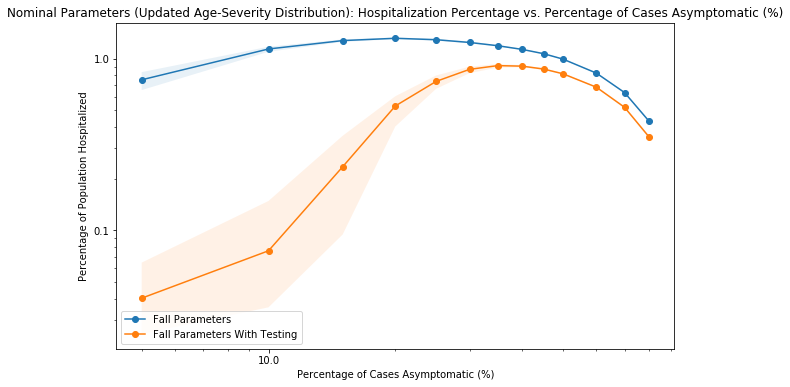

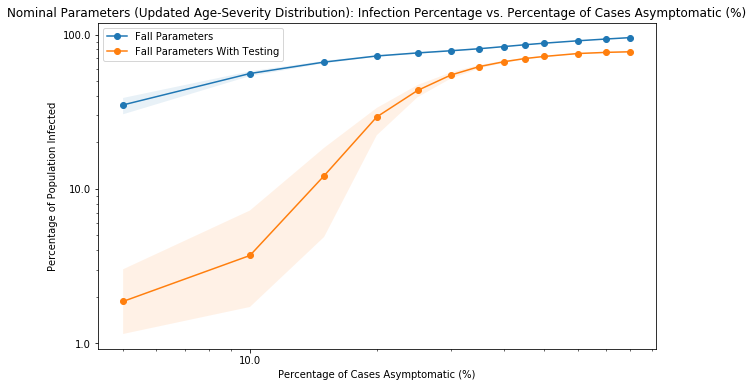

In [20]:

fall = updated_sim_results['fall_realistic_updated_age_severity']
fall_testing = updated_sim_results['fall_realistic_updated_age_severity_testing']

for sublabel in ['asymptomatic_p']:
    
    plot_many_dfs_quantiles({'Fall Parameters': fall[sublabel],
                             'Fall Parameters With Testing': fall_testing[sublabel]}, 
                            cum_severe_quantiles,
                            normalize_params[sublabel], x_log_scale=plot_log_scale[sublabel],
                     xlabel=plot_labels[sublabel], ylabel="Percentage of Population Hospitalized",
                     title="Nominal Parameters (Updated Age-Severity Distribution): Hospitalization Percentage vs. {}".format(plot_labels[sublabel]), 
                               q_low=0.1, q_high=0.9, alpha=0.1, y_min = 0, y_max=5, y_log_scale=True,
                             use_x_int_labels=False)
    
    plot_many_dfs_quantiles({'Fall Parameters': fall[sublabel],
                             'Fall Parameters With Testing': fall_testing[sublabel]}, 
                            cum_infection_quantiles,
                            normalize_params[sublabel], x_log_scale=plot_log_scale[sublabel],
                     xlabel=plot_labels[sublabel], ylabel="Percentage of Population Infected",
                     title="Nominal Parameters (Updated Age-Severity Distribution): Infection Percentage vs. {}".format(plot_labels[sublabel]), 
                               q_low=0.1, q_high=0.9, alpha=0.1, y_min = 0, y_max=5, y_log_scale=True,
                             use_x_int_labels=False)